In [1]:
from models.biscuit_nf import BISCUITNF
import torch
from typing import List, Tuple, Dict, Any, Union, Optional
device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoencoder_path = ''
model_path = '/home/gkounto/BISCUIT/experiments/BISCUIT/8gf65ir8/checkpoints/epoch=344-step=26910.ckpt'
model = BISCUITNF.load_from_checkpoint(model_path)
model.to(device)
model.freeze()
_ = model.eval()

In [ ]:
encodings_path = '/home/gkounto/BISCUIT/experiments/pretrained_models/AE_gridworld_small/encodings/gridworld_small_pre_intv_freeze_test.pt'
encodings = torch.load(encodings_path)

In [9]:
from experiments.datasets import GridworldDataset
data_folder = '/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified_5c'
# val_seq_dataset = GridworldDataset(
# data_folder=data_folder, split='val', return_targets=True, return_robot_state=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
train_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='train', return_targets=True, return_latents=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)

100


Loading sequences of train:   0%|          | 0/100 [00:00<?, ?it/s]

/scratch-local/gkounto/ipykernel_817122/3613320374.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(1, 2, 1)  # Frame subplot


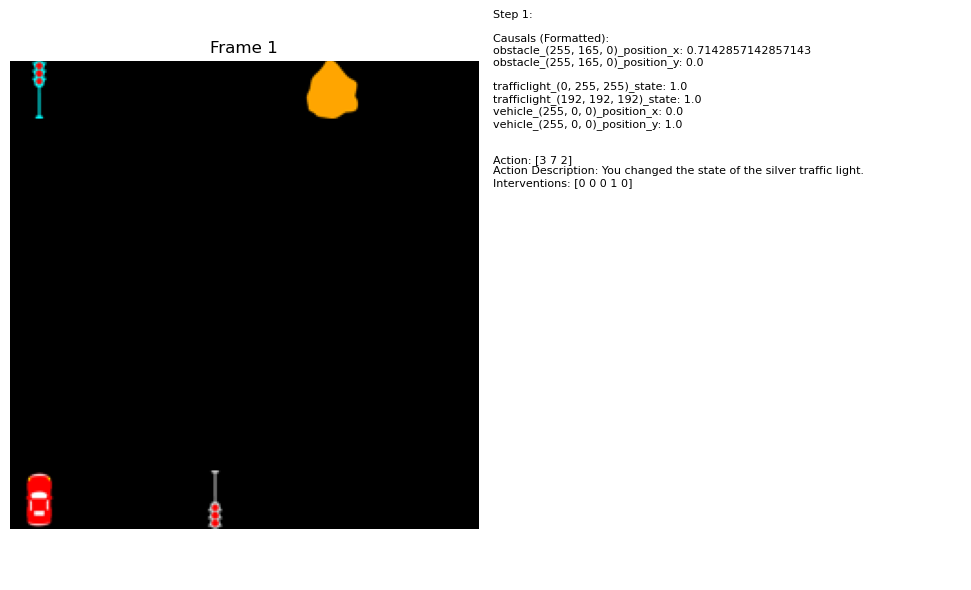

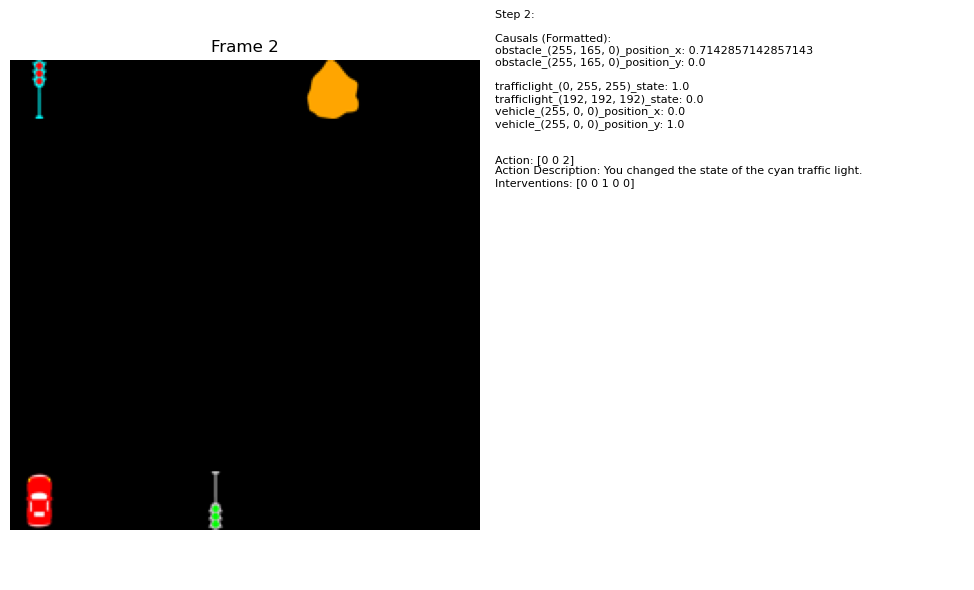

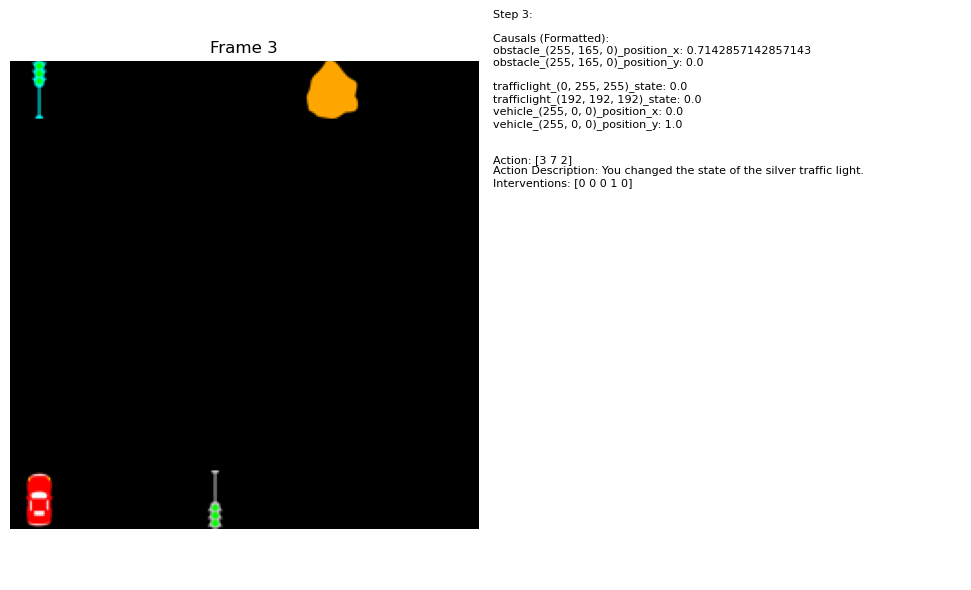

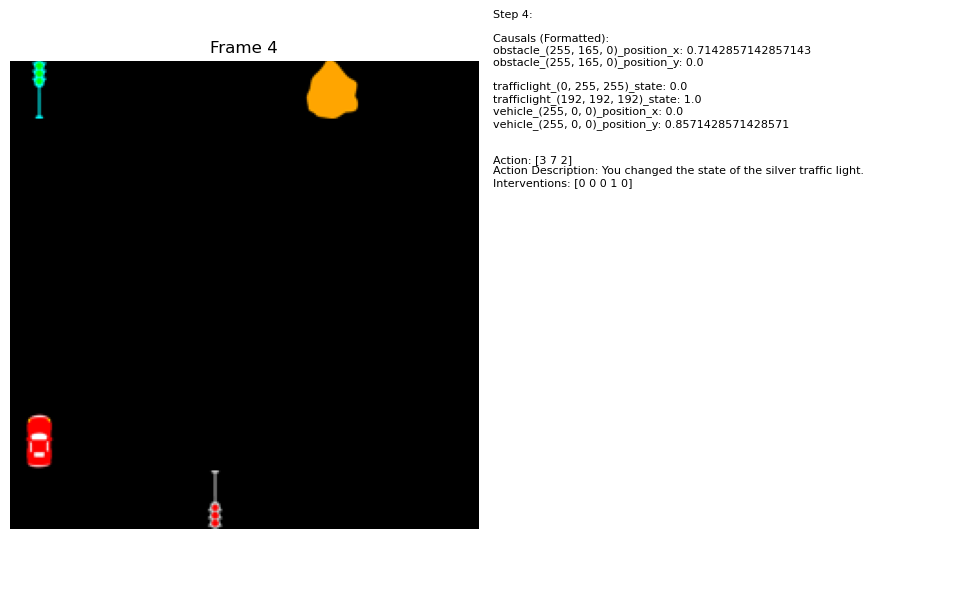

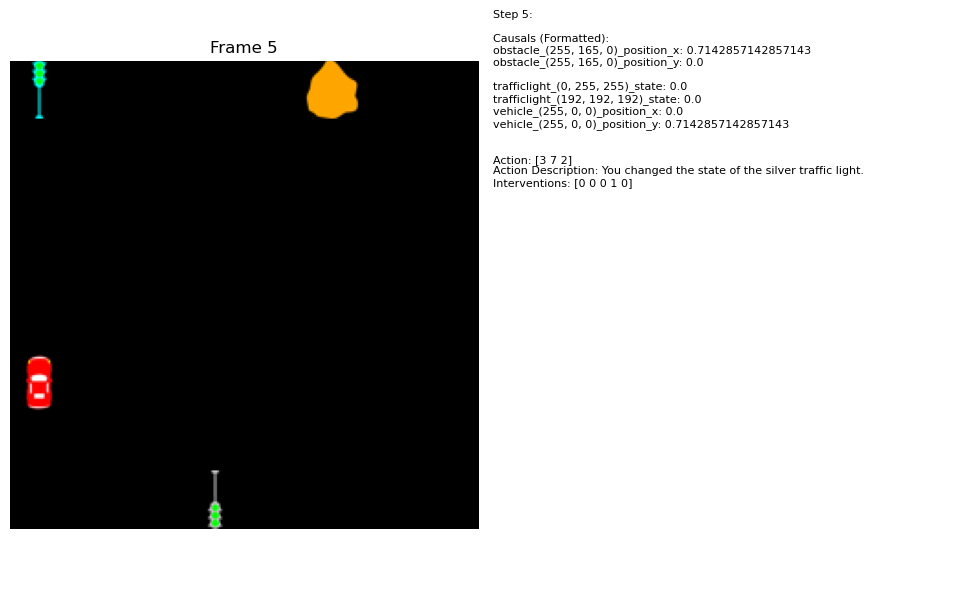

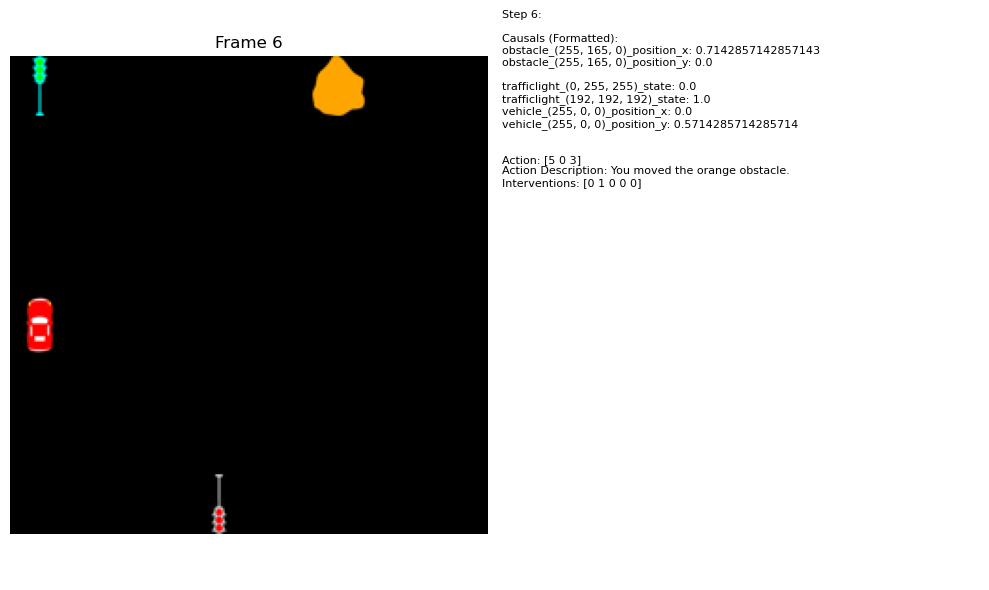

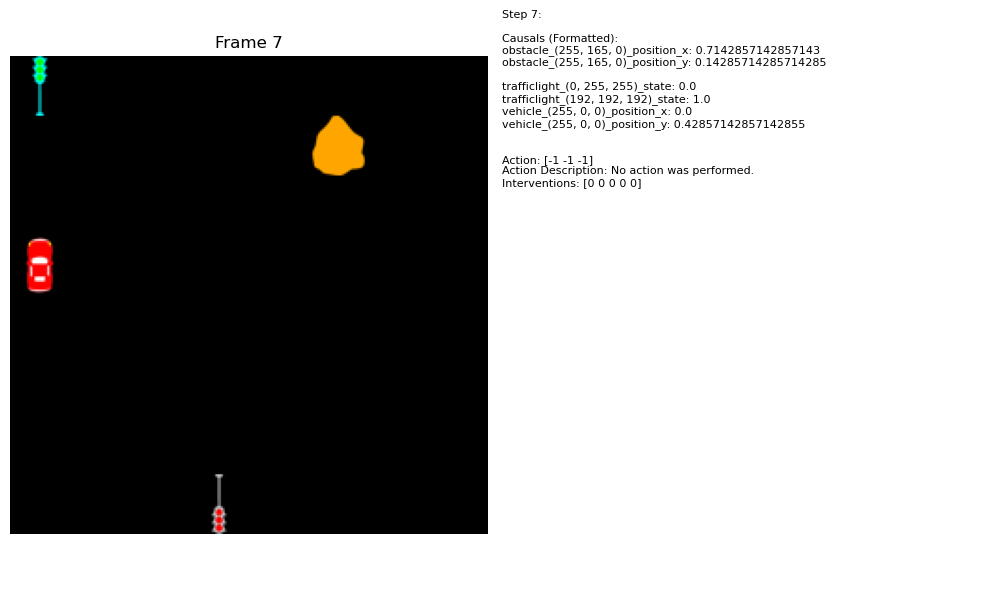

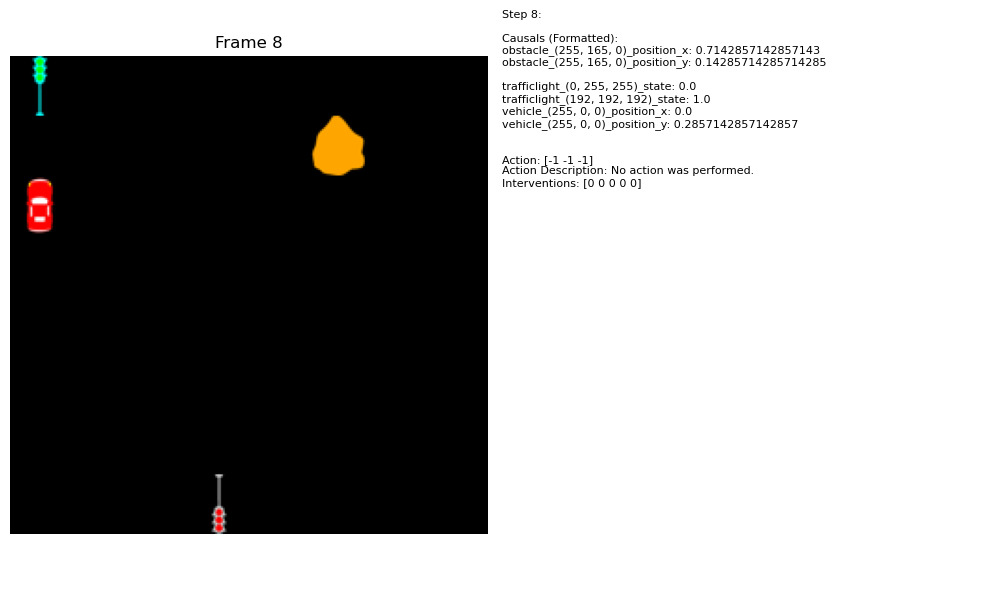

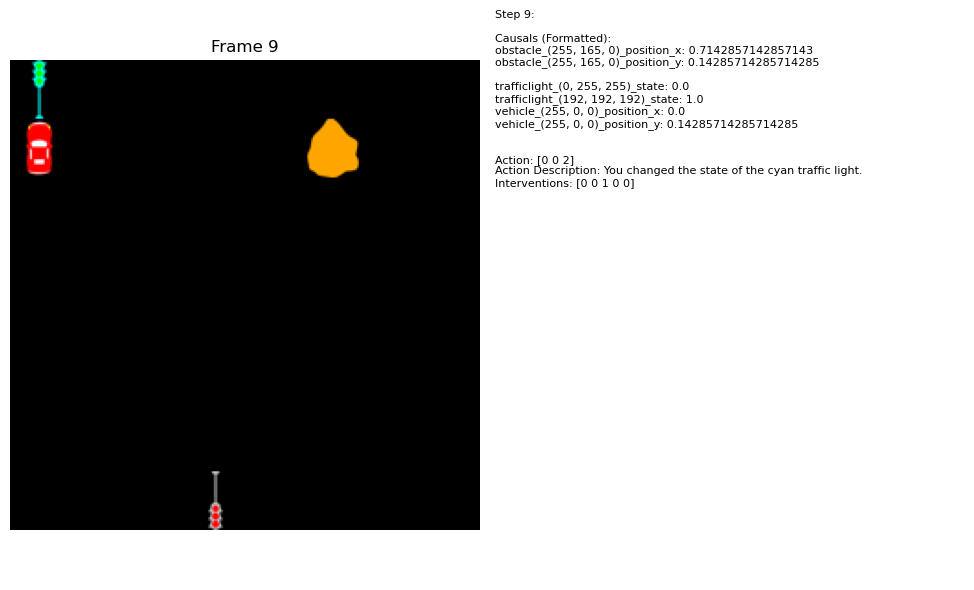

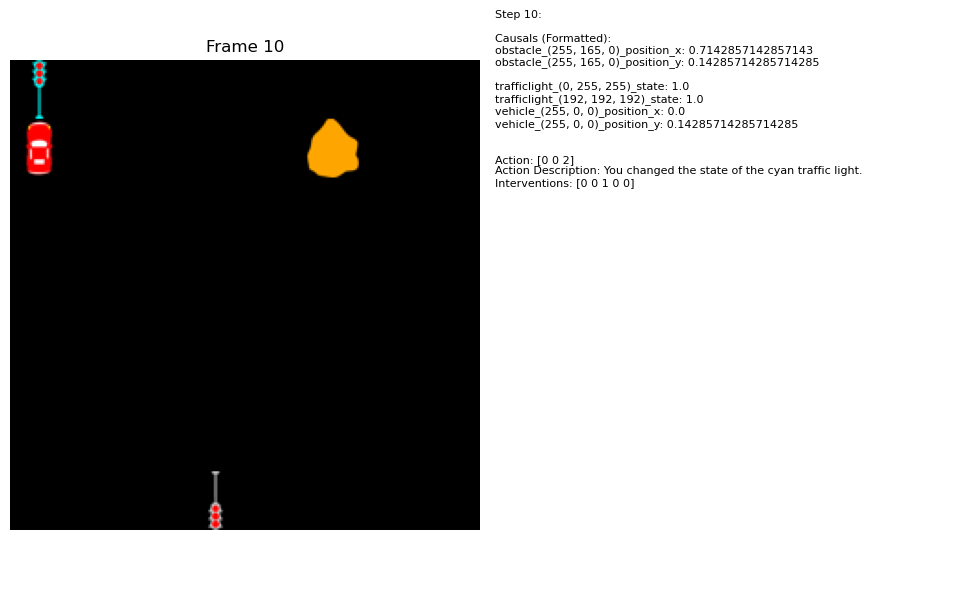

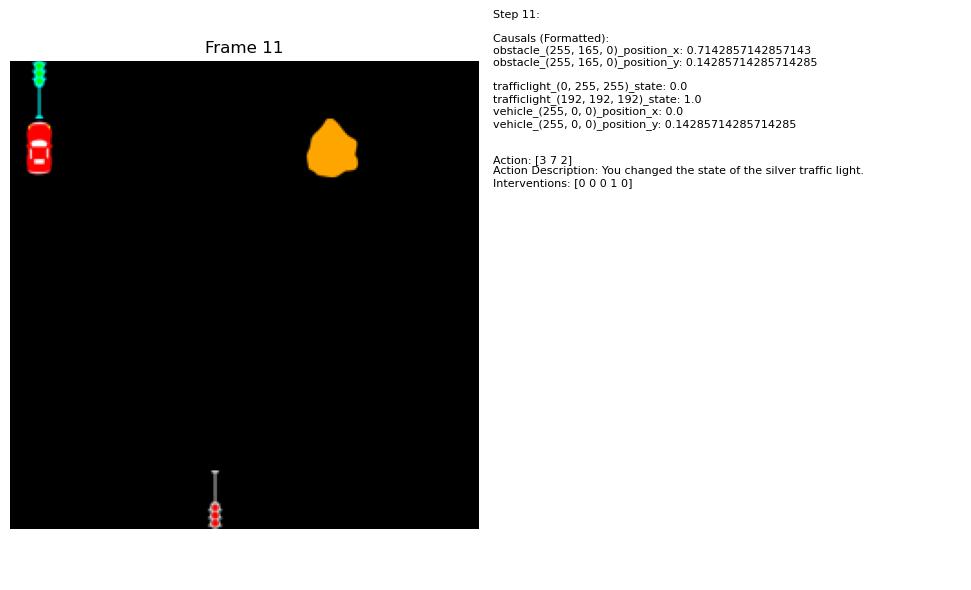

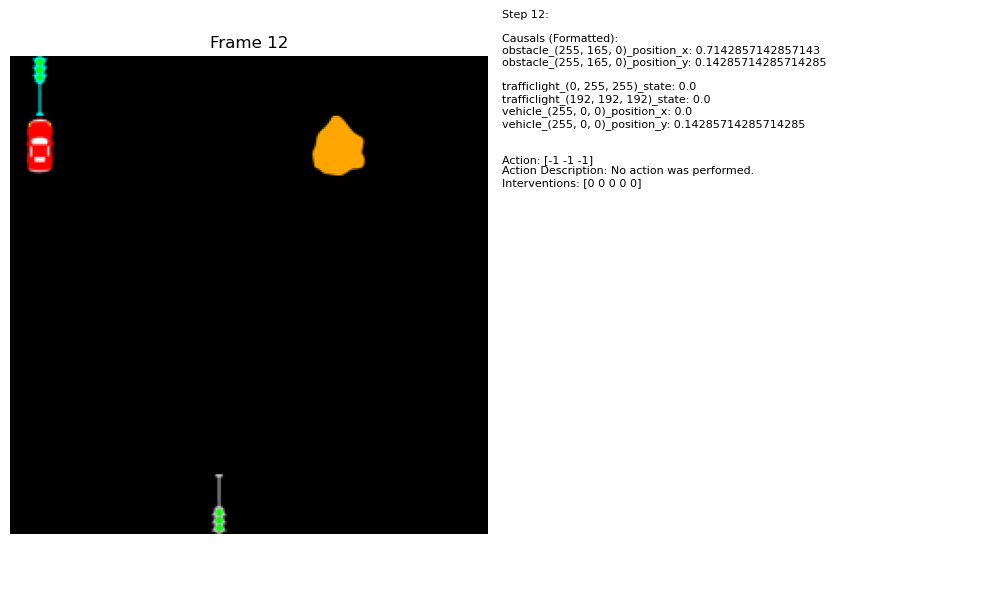

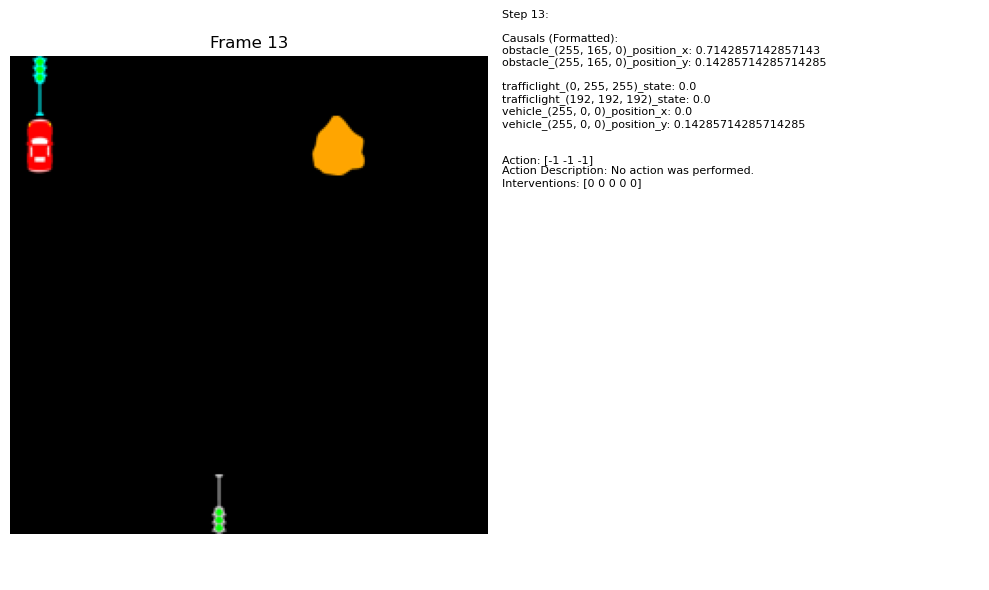

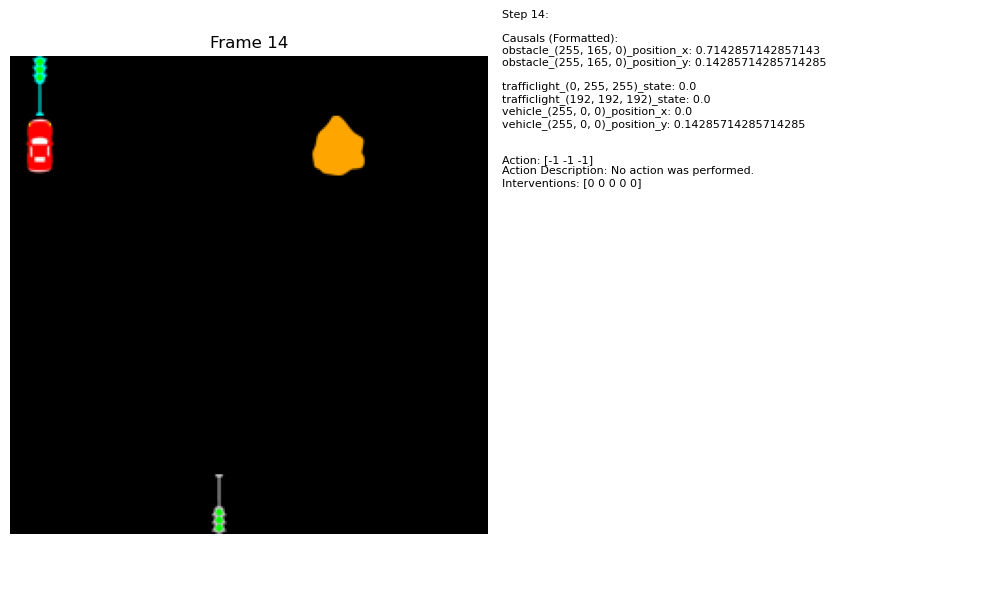

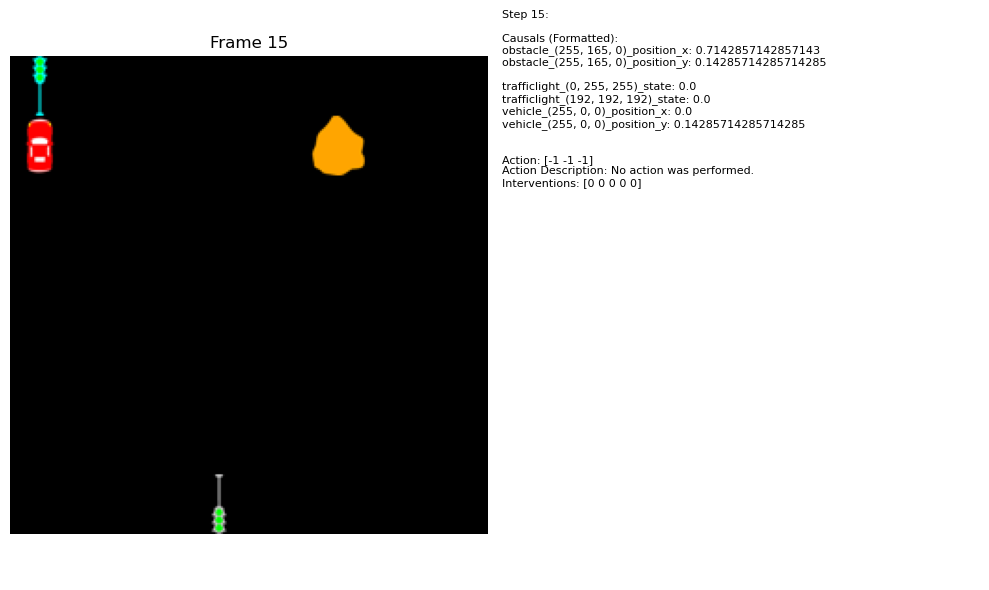

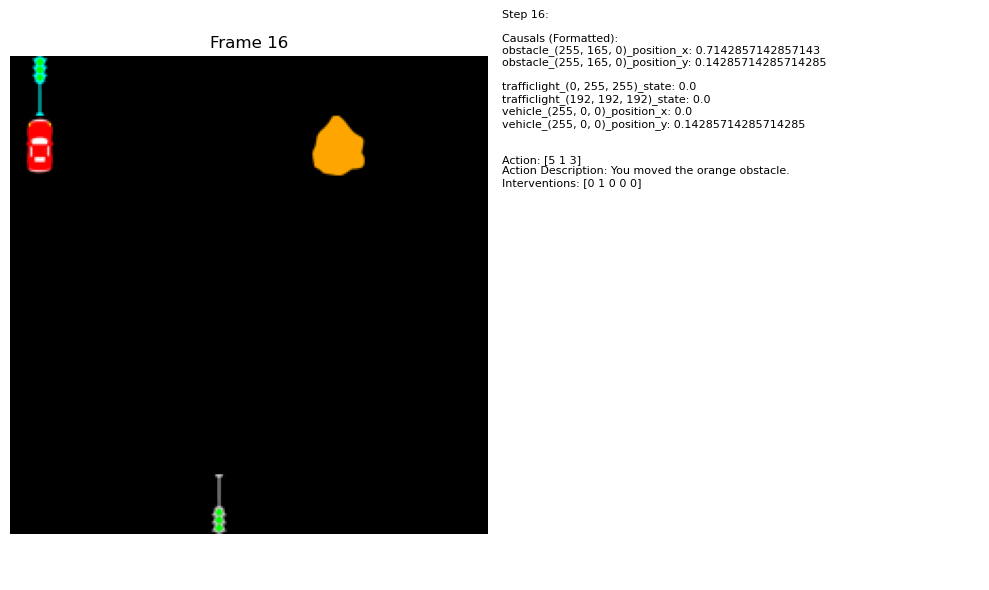

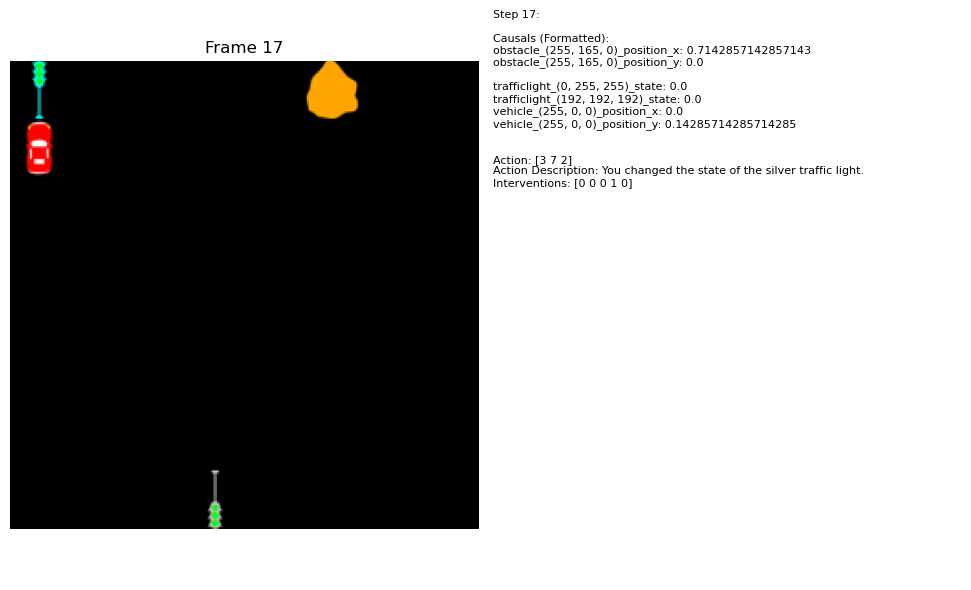

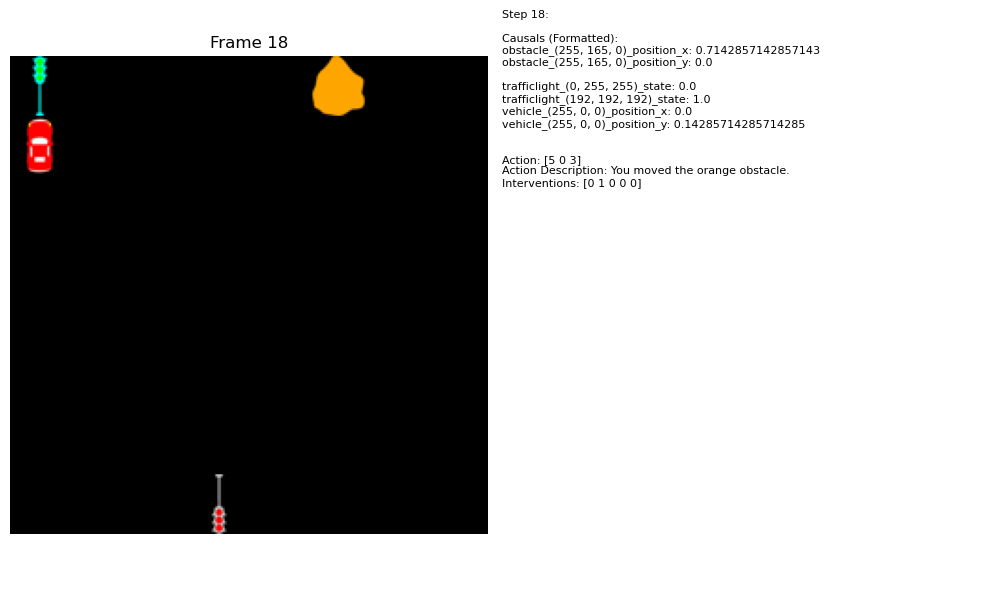

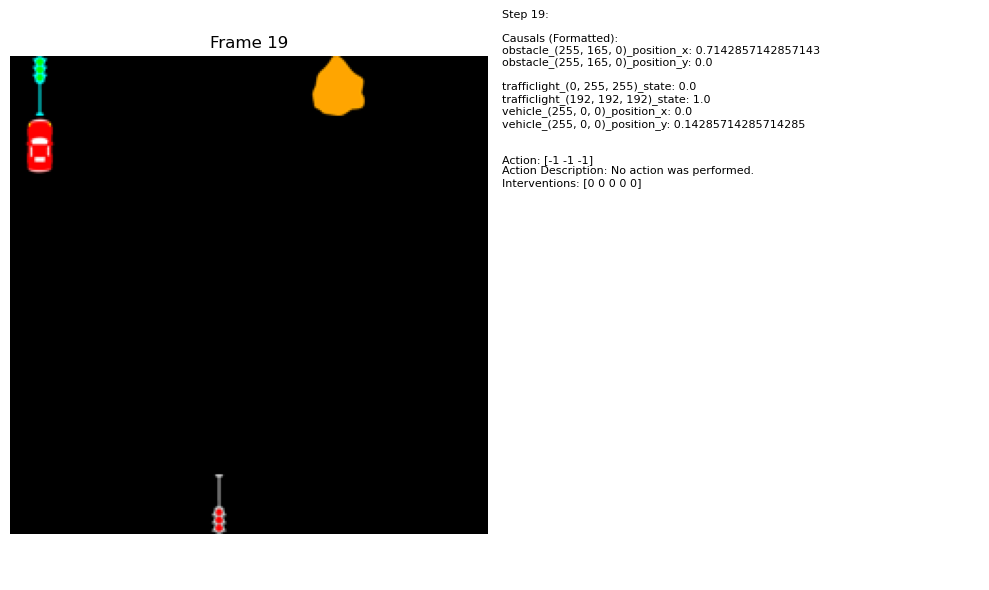

IndexError: index 19 is out of bounds for axis 0 with size 19

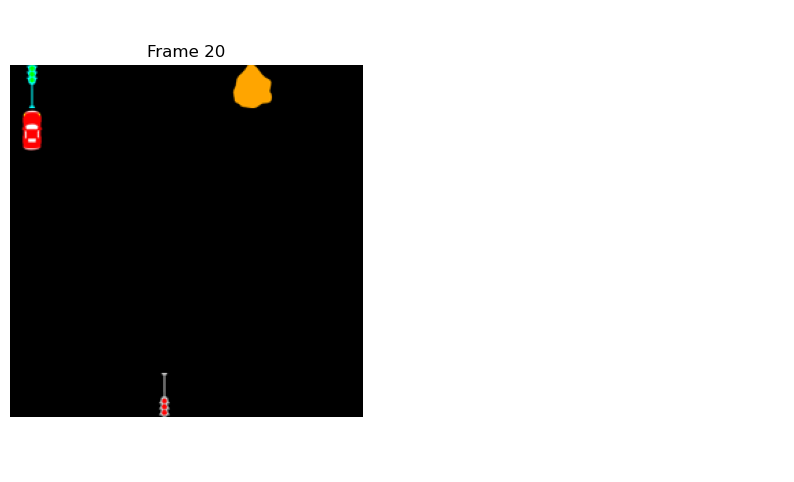

In [5]:
import numpy as np
import json
from data_generation.gridworld import Gridworld
from PIL import Image
import matplotlib.pyplot as plt

def format_causal_dict(causal_dict):
    formatted_text = ""
    for key, value in causal_dict.items():
        formatted_text += f"{key}: {value}\n"
        if "position_y" in key:  # Add a line break after each entity's details
            formatted_text += "\n"
    return formatted_text

def visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions):
    for i in range(len(frames)):
        debug_causals = Gridworld.causal_vector_to_debug_dict(causal_keys, causals[i])
        formatted_causals = format_causal_dict(debug_causals)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax1 = plt.subplot(1, 2, 1)  # Frame subplot
        ax1.imshow(frames[i])
        ax1.set_title(f"Frame {i+1}")
        ax1.axis('off')

        ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
        ax2.axis('off')
        text_info = (
            f"Step {i+1}:\n\n"
            f"Causals (Formatted):\n{formatted_causals}\n"
            f"Action: {actions[i]}\n"
            f"Action Description: {action_descriptions[i]}\n"
            f"Interventions: {interventions[i]}"
        )
        ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

        plt.tight_layout()
        plt.show()

a = np.load('/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified/train/gridworld_episode_0.npz')
causal_keys = json.load(open('/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified/train_metadata.json'))['causal_keys']
frames, causals, actions, interventions, action_descriptions = a['frames'], a['causals'], a['actions'], a['interventions'], a['action_descriptions']
visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import json
# Assume Gridworld, format_causal_dict, and the dataset class are defined elsewhere

def visualize_episodes(dataset, causal_keys, N=1):
    for episode_idx in range(min(N, len(dataset))):  # Loop through N episodes or the total dataset length
        frame_seq = dataset[episode_idx]  # Get the episode data
        frames, actions, interventions, causals = frame_seq
        
        for i in range(frames.shape[0] - 1):  # Iterate through each step, excluding the last frame
            # Map causals to keys for the current frame
            debug_causals = dict(zip(causal_keys, causals[i]))
            formatted_causals = format_causal_dict(debug_causals)

            fig, ax = plt.subplots(figsize=(10, 6))
            ax1 = plt.subplot(1, 2, 1)  # Frame subplot
            # Adjust image normalization if necessary
            img = (frames[i].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0  # Normalize if required
            ax1.imshow(img)
            ax1.set_title(f"Episode {episode_idx + 1}, Frame {i + 1}")
            ax1.axis('off')

            ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
            ax2.axis('off')
            text_info = (
                f"Episode {episode_idx + 1}, Step {i + 1}:\n\n"
                f"Causals (Formatted):\n{formatted_causals}\n"
                f"Action: {actions[i]}\n"
                f"Interventions: {interventions[i]}"
            )
            ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

            plt.tight_layout()
            plt.show()

# Example usage:
causal_keys = json.load(open('/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified/train_metadata.json'))['flattened_causals']
# Assuming train_seq_dataset is defined and loaded
visualize_episodes(train_seq_dataset, causal_keys, N=20)



In [5]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_img(imgs: Any,
             figure_title: str = None,
             titles: Optional[list] = None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 3.5, 3.5))
    if len(imgs) == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        if len(imgs[i].shape) == 3 and imgs[i].shape[0] in [3,4]:
            imgs[i] = imgs[i].permute(1, 2, 0)
        if isinstance(imgs[i], torch.Tensor):
            imgs[i] = imgs[i].detach().cpu().numpy()
        ax.imshow(imgs[i])
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i], weight='bold')
    if figure_title is not None:
        fig.suptitle(figure_title, weight='bold', size=16)
    plt.tight_layout()
    plt.show()

@torch.no_grad()
def next_step_prediction(
        image: torch.Tensor,
        action: torch.Tensor,
        gt_image: torch.Tensor = torch.zeros(1),
        latents: Optional[torch.Tensor] = None,
        plot_images: bool = True,
        intv_targets: Optional[torch.Tensor] = None,
        N: int = 8
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    if latents is None:
        input_image = (image * 2.0) - 1.0
        latents = model.autoencoder.encoder(input_image[None])
        latents, _ = model.flow.forward(latents)
    new_latents, _ = model.prior_t1.sample(latents, action[None], num_samples=1, intv_targets=intv_targets)
    new_latents = new_latents.squeeze(1)
    new_encodings = model.flow.reverse(new_latents)
    new_image = model.autoencoder.decoder(new_encodings)[0]
    new_image = (new_image + 1.0) / 2.0
    if plot_images:
        new_image_frame = new_image.permute(1, 2, 0).cpu().numpy()
        old_image_frame = (image.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
        clicked_image_frame = np.copy(old_image_frame)
        if action.ndim == 1:
            action = action[None]
        for i in range(action.shape[0]):
            if torch.any(action < 0) or torch.any(action > 1):
                continue
            # Correct calculation for pixel positions considering the normalized action coordinates
            pixel_x = int(action[i, 0].item() * (image.shape[-1] - 1))
            pixel_y = int(action[i, 1].item() * (image.shape[-2] - 1))
            # Highlight the click location with a red color
            clicked_image_frame[max(0, pixel_y-5):pixel_y+6, 
                                max(0, pixel_x-5):pixel_x+6, 
                                :] = np.array([1.0, 1.0, 1.0])
        if torch.any(gt_image != 0):
            show_img([old_image_frame, clicked_image_frame, new_image_frame, gt_image.permute(1, 2, 0).cpu().numpy()],
                     figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                     titles=['Previous Frame', 'Click Location', 'New Sample', 'Ground Truth'])
        else:
            show_img([old_image_frame, clicked_image_frame, new_image_frame],
                    figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                    titles=['Previous Frame', 'Click Location', 'New Sample'])
    return new_image, new_latents




In [2]:
from experiments.datasets import GridworldDataset
data_folder = '/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified_5c'
# val_seq_dataset = GridworldDataset(
# data_folder=data_folder, split='val', return_targets=True, return_robot_state=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
train_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='val', return_targets=False, return_latents=False, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)

10


Loading sequences of val:   0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
frame_seq = train_seq_dataset[5]
action = torch.tensor(frame_seq[1]).to(device).squeeze()
# intv_targets = torch.tensor(frame_seq[2]).to(device)
intv_targets = None
plot_images = True
new_image, new_latents = next_step_prediction(frame_seq[0][0], action, gt_image=frame_seq[0][1], plot_images=plot_images, intv_targets=intv_targets)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
import matplotlib.pyplot as plt
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow((train_seq_dataset[3][0][0].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0)
# ax[0].axis('off')
# ax[0].set_title('Initial Frame')
# ax[1].imshow((train_seq_dataset[3][0][1].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0)
# ax[1].axis('off')
# ax[1].set_title('Target Frame')

def show_sequence(seq, title):
    fig, ax = plt.subplots(1, len(seq), figsize=(len(seq) * 3.5, 3.5))
    for i in range(len(seq)):
        ax[i].imshow((seq[i].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0)
        ax[i].axis('off')
        ax[i].set_title(f'Frame {i+1}')
    fig.suptitle(title, weight='bold', size=16)
    plt.tight_layout()
    plt.show()
    
show_sequence(train_seq_dataset[5][0], 'Initial Frame and Target Frame')

In [ ]:
train_seq_dataset[5]